## Overview

1. [Single Cell Model](#single-cell-model)
2. [Network Simulations](#network-simulations)
3. [Fit of the Transfer Function (to do)](#fit-of-the-transfer-function)
4. [Mean Field Model](#mean-field-model)
5. [Whole Brain Model](#whole-brain-model)
6. [PCI](#pci)
7. [BOLD and FC](#bold-and-fc)
8. [Dynamical Analysis (to do)](#dynamical-analysis)

In [1]:
%matplotlib widget

In [1]:
%precision 2
%load_ext autoreload
%autoreload 2

In [2]:
%run setup.py

Everything is now installed. You can proceed. 


<a class="anchor" id="single-cell-model"></a>
### Single Cell Model

In this implementations we select the **AdEx model**, described as following: 


$c_{m}  \frac{dv}{dt}  =  g_L(E_L-v)+ g_L\Delta e^{\frac{v-v_{thr}}{\Delta }} -W + I_{syn}$  

$\frac{dW}{dt}  =  -\frac{1}{\tau_w} (a(v-E_L) - W) + b \sum_{t_{sp}}\delta(t-t_{sp})$

These equations are used in the `eqs` variable of the Brian implementation.

You can select a different model and adjust the `eqs` and the relevant parameters of the model accordingly.

In [103]:
#These are the arguments and default values - to try different parameters refer to the script
%run single_cell_sim.py --help

usage: single_cell_sim.py [-h] [--b_e B_E] [--iext IEXT] [--tau_e TAU_E]
                          [--tau_i TAU_I] [--time TIME]

optional arguments:
  -h, --help     show this help message and exit
  --b_e B_E      adaptation (pA) (default: 60)
  --iext IEXT    input current (nA) (default: 0.3)
  --tau_e TAU_E  excitatory synaptic decay (ms) (default: 5.0)
  --tau_i TAU_I  inhibitory synaptic decay (ms) (default: 5.0)
  --time TIME    Total Time of simulation (ms) (default: 200)


Simulation of a single neuron. In this case we simulate the activity of a regular spiking cell, with adaptation.

8.0


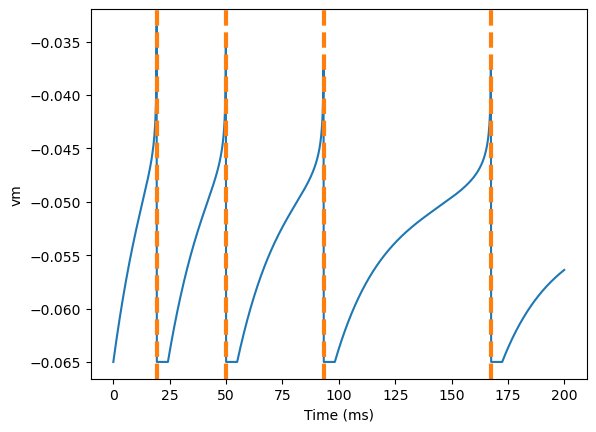

In [8]:
%run single_cell_sim.py --type='RS'

<a id="network-simulations"></a>
### Network Simulations

In [106]:
#These are the arguments and default values - for more changes go to the script
%run adex_simulation_network.py --help

usage: adex_simulation_network.py [-h] [--b_e B_E] [--iext IEXT]
                                  [--tau_e TAU_E] [--tau_i TAU_I]
                                  [--time TIME]

optional arguments:
  -h, --help     show this help message and exit
  --b_e B_E      adaptation (pA) (default: 0.0)
  --iext IEXT    external input (Hz) (default: 0.5)
  --tau_e TAU_E  excitatory synaptic decay (ms) (default: 5.0)
  --tau_i TAU_I  inhibitory synaptic decay (ms) (default: 5.0)
  --time TIME    Total Time of simulation (ms) (default: 1000)


V_m=-60 , a_i=0, a_e=0, V_r=-65, tau_i=5.0, tau_e=5.0, b_i=0, b_e=10.0, delta_i=0.5, delta_e=2, V_th=-50, EL_i=-65, EL_e=-64, Vcut_i=-30, Vcut_e=-30
--##Start simulation##--
--##End simulation##--


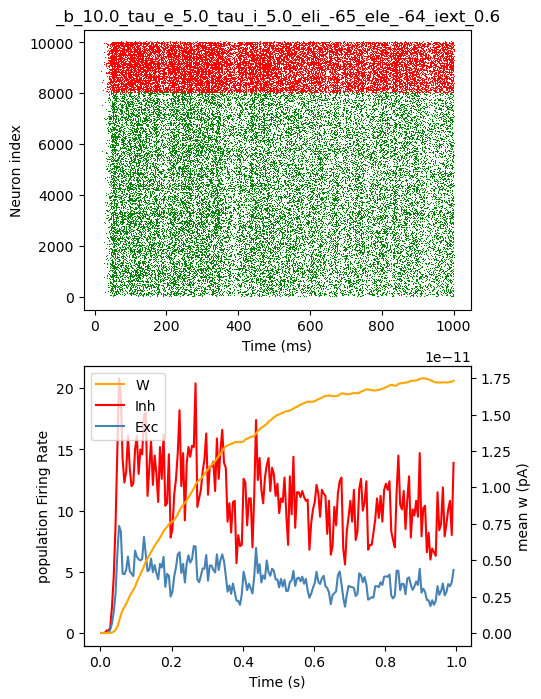

 done


In [7]:
%run adex_simulation_network.py --b_e=10.0 --iext=0.6

In [5]:
params_file = './data/params_range_trial.npy'
feSim, fiSim, params = np.load(params_file,allow_pickle=True) 

In [22]:
params

{'V_m': -60,
 'a_e': 0,
 'a_i': 0,
 'V_r': -65,
 'tau_e': 5,
 'tau_i': 5,
 'b_e': 30,
 'b_i': 0,
 'delta_e': 2,
 'delta_i': 0.50,
 'Vcut_e': -30,
 'Vcut_i': -30,
 'EL_e': -64,
 'EL_i': -65,
 'V_th': -50,
 'E_e': 0,
 'E_i': -80,
 'Cm': 200,
 'Gl': 10,
 'tau_w': 500,
 'p_con': 0.05,
 'gei': 0.20,
 'Ntot': 10000,
 'Q_i': 5.00,
 'Q_e': 1.50}

In [5]:
# Now making the numerical simulations at various levels of both excitatory and inhibitory inputs
%run Tf_calc/tf_simulation.py --cells FS-RS --range_inh 0.1,30,50 --range_exc 0.1,30,50 --time 4000 
# paper's value -> 5-10 minutes sim

rate exc = 0.1
rate inh = 0.1


WARNING    'Cm' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Cm' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


rate inh = 0.710204081632653


WARNING    'Cm' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Cm' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


rate inh = 1.3204081632653062
rate inh = 1.9306122448979592
rate inh = 2.5408163265306123
rate inh = 3.1510204081632653
rate inh = 3.7612244897959184
rate inh = 4.371428571428571
rate inh = 4.981632653061224
rate inh = 5.591836734693877
rate inh = 6.20204081632653
rate inh = 6.812244897959183
rate inh = 7.422448979591836
rate inh = 8.03265306122449
rate inh = 8.642857142857142
rate inh = 9.253061224489796
rate inh = 9.863265306122448
rate inh = 10.4734693877551
rate inh = 11.083673469387755
rate inh = 11.693877551020408
rate inh = 12.30408163265306
rate inh = 12.914285714285713
rate inh = 13.524489795918367
rate inh = 14.13469387755102
rate inh = 14.744897959183673
rate inh = 15.355102040816325
rate inh = 15.965306122448979
rate inh = 16.575510204081635
rate inh = 17.185714285714287
rate inh = 17.79591836734694
rate inh = 18.406122448979595
rate inh = 19.016326530612247
rate inh = 19.6265306122449
rate inh = 20.23673469387755
rate inh = 20.846938775510203
rate inh = 21.45714285714286
r

In [24]:
%run Tf_calc/theoretical_tools --help

usage: theoretical_tools.py [-h] [-f FILE] [--cell CELL]
                            [--params_file PARAMS_FILE] [--With_Square]

 
     '=================================================='
     '=====> FIT of the transfer function =============='
     '=== and theoretical objects for the TF relation =='
     '=================================================='
     

options:
  -h, --help            show this help message and exit
  -f FILE, --FILE FILE  file name of numerical TF data
  --cell CELL           type of cell
  --params_file PARAMS_FILE
                        parameter file
  --With_Square         Add the square terms in the TF formula
                         then we have 7 parameters


In [3]:
file = './data/ExpTF_inh_50x50_trial.npy'
cell = 'FS'
param_file = './data/params_range_trial.npy'

feSim, fiSim, params = np.load(param_file,allow_pickle=True) 
params

{'V_m': -60,
 'V_r': -65,
 'Cm': 200,
 'Gl': 10,
 'tau_w': 500,
 'V_th': -50,
 'V_cut': -30,
 'a_e': 0,
 'b_e': 30,
 'delta_e': 2,
 'EL_e': -64,
 'a_i': 0,
 'b_i': 0,
 'delta_i': 0.50,
 'EL_i': -65,
 'tau_e': 5,
 'tau_i': 5,
 'E_e': 0,
 'E_i': -80,
 'Q_i': 5.00,
 'Q_e': 1.50,
 'p_con': 0.05,
 'gei': 0.20,
 'Ntot': 10000}

In [53]:
file = './data/ExpTF_inh_50x50_trial.npy'
cell = 'FS'
param_file = './data/params_range_trial.npy'
adapt_file= "./data/ExpTF_Adapt_inh_50x50_trial.npy"

In [98]:
FF = np.load(file)

FF2 = FF[:25][:,:25]

In [88]:
range_exc, range_inh, params = np.load(param_file, allow_pickle=True
)

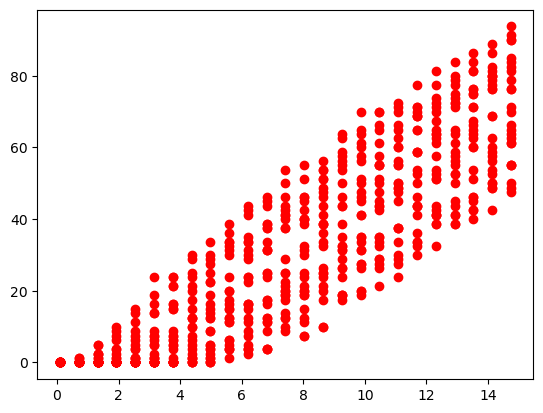

In [99]:
fig, ax = plt.subplots()

ax.plot(range_exc[:25], FF2, 'ro');

In [56]:
from Tf_calc.theoretical_tools_jor_fed import  make_fit_from_data_fede

file = './data/ExpTF_inh_50x50_trial.npy'
cell = 'FS'
param_file = './data/params_range_trial.npy'
adapt_file= "./data/ExpTF_Adapt_inh_50x50_trial.npy"

P = make_fit_from_data_fede(file, cell, param_file, adapt_file,range_exc=(0,15), range_inh=(0,15))
# make_fit_from_data_2(file, cell, param_file, with_square_terms=True)

this many nans: 405
fitting first order V threshold..
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.260680747008962e-08
            Iterations: 66
            Function evaluations: 756
            Gradient evaluations: 66
P =  [-0.04900086  0.02175163 -0.02848895  0.07578546  0.00023634 -0.02569956
 -0.01503253 -0.00062187  0.05016558 -0.00401017]
Fitting Transfer Function..
loop n: 0


WARNING    /DATA/Maria/paper_pipeline/Tf_calc/theoretical_tools_jor_fed.py:383: RuntimeWarning: Maximum number of iterations has been exceeded.
  fit2 = minimize(res2_func, params_init2,
 [py.warnings]


2024-04-19 19:30:12,273 - WARNING - py.warnings - /DATA/Maria/paper_pipeline/Tf_calc/theoretical_tools_jor_fed.py:383: RuntimeWarning: Maximum number of iterations has been exceeded.
  fit2 = minimize(res2_func, params_init2,

mean error =  4.9341362863875355
loop n: 1
mean error =  5.523822104694183
loop n: 2
mean error =  5.955620347897239
loop n: 3
mean error =  5.537993551240165
loop n: 4
mean error =  3.8738976913876977
loop n: 5
mean error =  5.103668894031839
loop n: 6
mean error =  4.662366886563778
loop n: 7
mean error =  4.807890108155753
loop n: 8
mean error =  4.31941361344237
loop n: 9
mean error =  5.12788629398038
coefficients saved in  ./data/ExpTF_inh_50x50_trial_FS__fit.npy


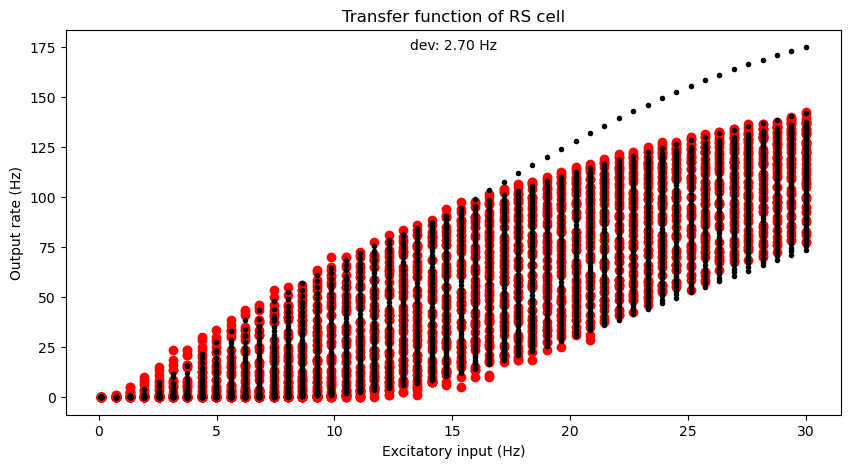

In [77]:
cell_type='RS'
P=np.load(f'./data/ExpTF_exc_50x50_trial_{cell_type}__fit.npy')
file = './data/ExpTF_exc_50x50_trial.npy'

plot_check_fit(file, param_file, adapt_file ,cell_type, P)

In [28]:
from Tf_calc.theoretical_tools import *

In [161]:
P = np.load('./data/ExpTF_inh_50x50_trial_FS_fede_fit.npy')
adapt = np.load("./data/ExpTF_Adapt_inh_50x50_trial.npy")
file = './data/ExpTF_inh_50x50_trial.npy'
cell_type = 'FS'
param_file = './data/params_range_trial.npy'

feSim, fiSim, params = np.load(param_file,allow_pickle=True) 

In [246]:
x_start

0

In [163]:
from scipy.ndimage import maximum_filter


mean error =  2.2277421948251015


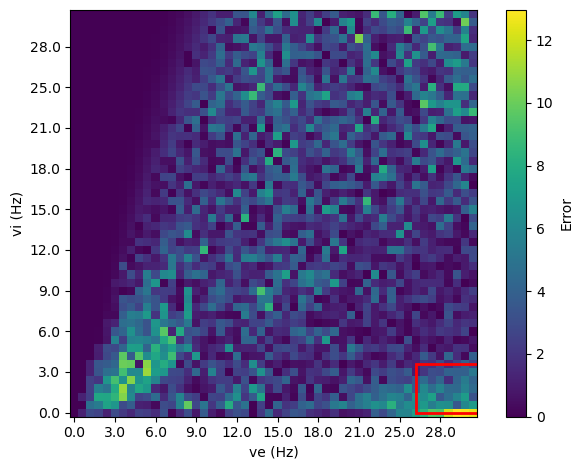

In [29]:
plot_example_adjust_range(file, param_file, adapt_file ,cell_type, P, window=5)

In [306]:
def refill_nans(array_original, array_nonan, bigindex):
    array_new = np.zeros_like(array_original.flatten())
    array_new[bigindex] = np.nan

    # array_new = np.empty_like(array_original.flatten())
    # array_new[:] = np.nan
    # array_new[bigindex] = 0

    c=0
    for i in range(len(array_new)):
        if np.isnan(array_new[i]):
            c+=1
            pass
        else:
            array_new[i] = array_nonan.flatten()[i-c]
    
    return array_new.reshape(array_original.shape)

In [327]:
def reshape_with_nans(vve, vvi, adapt, FF, params, cell_type):
    ve2, vi2, FF2, adapt2, bigindex = get_rid_of_nans(vve, vvi, adapt, FF, params, cell_type, return_index=True)

    vve_new = refill_nans(vve, ve2, bigindex)
    vvi_new = refill_nans(vvi, vi2, bigindex)
    adapt_new = refill_nans(adapt, adapt2, bigindex)
    FF_new = refill_nans(FF, FF2, bigindex)

    # vve_new = refill_nans(vve, vve, bigindex)
    # vvi_new = refill_nans(vvi, vvi, bigindex)
    # adapt_new = refill_nans(adapt, adapt, bigindex)
    # FF_new = refill_nans(FF, FF, bigindex)

    return vve_new, vvi_new, adapt_new, FF_new


In [329]:
vve_new, vvi_new, adapt_new, FF_new = reshape_with_nans(vve, vvi, adapt, FF, params, cell_type)

this many nans: 405


(2095,)


Text(0.5, 0.95, 'dev: nan Hz')

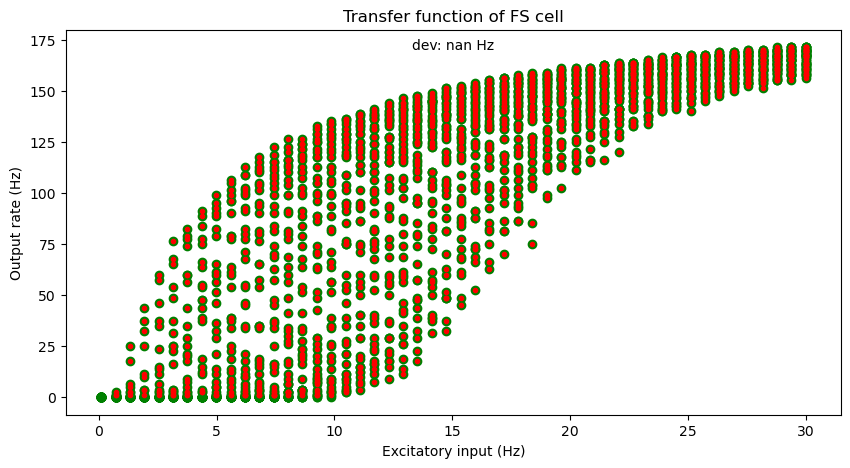

In [280]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Transfer function of FS cell')
ax.set_ylabel('Output rate (Hz)')
ax.set_xlabel('Excitatory input (Hz)')
    
inp_exc = feSim
vve, vvi = np.meshgrid(feSim, fiSim)
out_rate = np.load(file)

ve2, vi2, FF2, adapt2 = get_rid_of_nans(vve, vvi, adapt, FF, params, cell_type)

mu_V, sig_V, tau_V = mu_sig_tau_func(vve_new, vvi_new, adapt_new,params,cell_type)
g_L = 10 * 1e-9   # 30.0  /1.3
C_m = 200 * 1e-12  # 281.0 /1.1
tauN_V = tau_V * g_L / C_m

fit_rate = output_rate(P,mu_V, sig_V, tau_V, tauN_V)
# ax.plot(vi, fit_rate, 'k.', label='fit');
ax.plot(ve, FF, 'go', label='data');
ax.plot(ve, FF_new, 'r.', label='data');

mean_error = np.mean(np.sqrt((FF_new - fit_rate)**2))

ax.text(0.5, 0.95, f'dev: {mean_error:.2f} Hz', transform=ax.transAxes, ha='center')

In [410]:
P = np.load('./data/ExpTF_inh_50x50_trial_FS_fede_fit.npy')
adapt = np.load("./data/ExpTF_Adapt_inh_50x50_trial.npy")
adapt_file = "./data/ExpTF_Adapt_inh_50x50_trial.npy"
file = './data/ExpTF_inh_50x50_trial.npy'
cell_type = 'FS'
param_file = './data/params_range_trial.npy'


In [107]:
des_start = 0
des_end = 30
start = np.argmin(np.abs(vi - des_start))
end = np.argmin(np.abs(vi - des_end))
rid = range(start,end)


des_start = 15
des_end = 30
start = np.argmin(np.abs(ve - des_start))
end = np.argmin(np.abs(ve - des_end))
red = range(start, end)

In [49]:
desired_value = 10
closest_index = np.argmin(np.abs(vi - desired_value))
closest_index

16

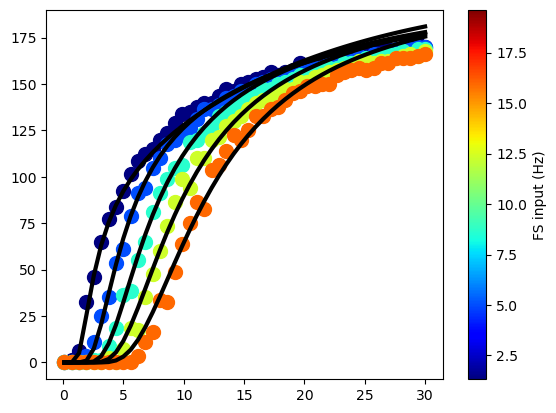

In [422]:
fig, ax = plt.subplots()
colormap = cm.jet
fs=[0,20,40,55,75,90]
index = 2
n_lines = 5
increment = 6

normalize = mcolors.Normalize(vmin=vi[index], vmax=vi[index + n_lines*increment])


for i in range(n_lines):
    # print(vi[index])
    ax.scatter(vve[index], out_rate.T[index], color=colormap(normalize(vi[index])), s=100)
    ax.plot(vve[index].squeeze(), fit_rate.T[index].squeeze(), 'k',  linewidth=3.0, label='fit')

    index+=increment
# ax.set_ylim(0.,50)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(vi)
plt.colorbar(scalarmappaple, label='FS input (Hz)')
plt.show()

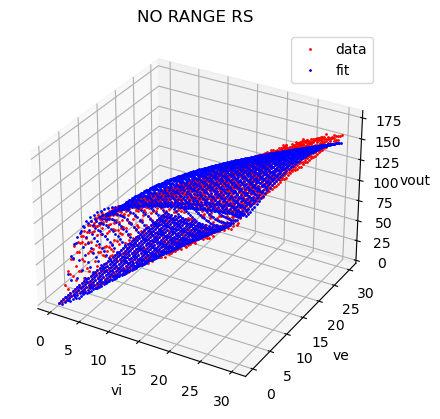

In [396]:
# Create a new figure
fig = plt.figure()

# Create axes for the 3D plot
ax = fig.add_subplot(111, projection='3d')

# Plot the data
# ax.plot3D(vvi.flatten(), vve.flatten(), FS.flatten(), 'ob', markersize=1, label='FS')
ax.plot3D(vvi.flatten(), vve.flatten(), out_rate.flatten(), 'or', markersize=1, label='data')
ax.plot3D(vvi.flatten(), vve.flatten(), fit_rate.flatten(), 'ob', markersize=1, label='fit')

# Set labels for the axes
ax.set_xlabel('vi')
ax.set_ylabel('ve')
ax.set_zlabel('vout')

ax.set_title("NO RANGE RS")

# Add a legend
ax.legend()

# Display the plot
plt.show()

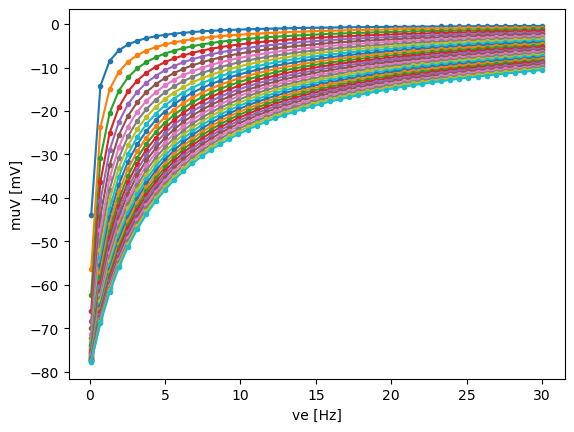

In [43]:
plot_muv(vve, vvi, adapt,)

In [35]:
vi = fiSim

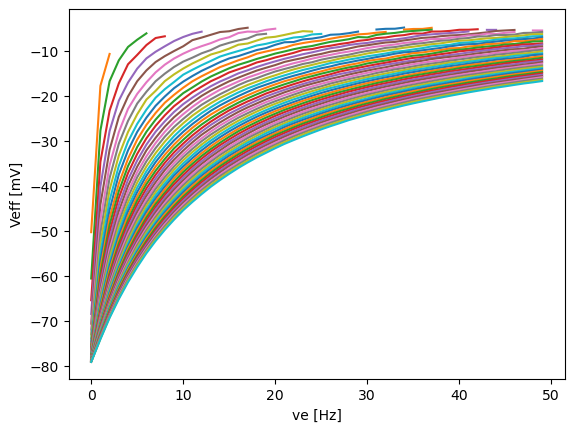

In [47]:
plot_veff(vve, vvi, adapt, out_rate)

In [45]:
out_rate.shape

(50, 50)

In [13]:
adapt_fs = np.zeros_like(adapt)
adapt_fs.shape

(50, 50)

In [14]:
np.save("./data/ExpTF_Adapt_inh_50x50_trial.npy", adapt_fs)

In [157]:
ve, vi, params = np.load(param_file,allow_pickle=True)
FF= np.load(file)
PP = np.load('./data/ExpTF_inh_50x50_trial_fit.npy')

muV, sV, Tv, TvN = MPF(vve, vvi, FF, params, cell_type)


In [81]:
%matplotlib inline

In [10]:
ve = feSim
vi= fiSim

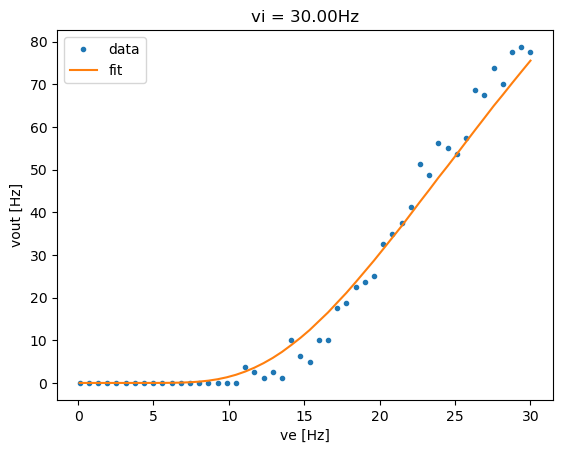

In [31]:
video_check_fit(file, param_file, adapt_file ,cell_type, P)

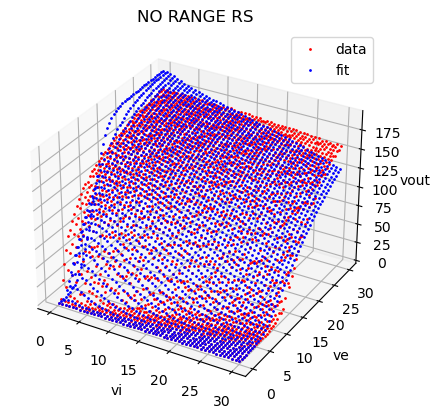

In [67]:
# Create a new figure
fig = plt.figure()

# Create axes for the 3D plot
ax = fig.add_subplot(111, projection='3d')

# Plot the data
# ax.plot3D(vvi.flatten(), vve.flatten(), FS.flatten(), 'ob', markersize=1, label='FS')
ax.plot3D(vvi.flatten(), vve.flatten(), FF.flatten(), 'or', markersize=1, label='data')
ax.plot3D(vvi.flatten(), vve.flatten(), TF(PP, muV, sV, Tv, TvN).flatten(), 'ob', markersize=1, label='fit')

# Set labels for the axes
ax.set_xlabel('vi')
ax.set_ylabel('ve')
ax.set_zlabel('vout')

ax.set_title("NO RANGE RS")

# Add a legend
ax.legend()

# Display the plot
plt.show()

<a id="fit-of-the-transfer-function"></a>
### Fit of the Transfer Function (to do)

<a id="mean-field-model"></a>
### Mean Field Model

In [62]:
from Tf_calc.cell_library import get_neuron_params_double_cell

params = get_neuron_params_double_cell('FS-RS')

params

{'V_m': -60,
 'a_e': 0,
 'a_i': 0,
 'V_r': -65,
 'tau_e': 5,
 'tau_i': 5,
 'b_e': 30,
 'b_i': 0,
 'delta_e': 2,
 'delta_i': 0.50,
 'El_e': -64,
 'El_i': -65,
 'V_th': -50,
 'E_e': 0,
 'E_i': -80,
 'Cm': 200,
 'Gl': 10,
 'tau_w': 500,
 'p_con': 0.05,
 'gei': 0.20,
 'Ntot': 10000,
 'Q_i': 5.00,
 'Q_e': 1.50}

In [32]:
%run MF_script_with_OS.py --help

usage: MF_script_with_OS.py [-h] [--b_e B_E] [--iext IEXT] [--tau_e TAU_E]
                            [--tau_i TAU_I] [--time TIME]

optional arguments:
  -h, --help     show this help message and exit
  --b_e B_E      adaptation - in pA
  --iext IEXT    external input - in Hz
  --tau_e TAU_E  excitatory synaptic decay - in ms
  --tau_i TAU_I  inhibitory synaptic decay - in ms
  --time TIME    Total Time of simulation - in s


In [ ]:
P[0] ok
P[1] ok 


In [34]:
PRS=np.load('RS-cell0_CONFIG1_fit.npy')
PFS=np.load('FS-cell_CONFIG1_fit.npy')

PRS

array([-0.05017034,  0.00451531, -0.00794377, -0.00208418,  0.001     ,
       -0.00054697,  0.00341614, -0.01156433,  0.00194753,  0.00274079,
       -0.01066769])

In [41]:
np.save('RS-cell0_CONFIG1_fit_2.npy', PR2)
np.save('FS-cell_CONFIG1_fit_2.npy', PF2)

In [40]:

PF2 = np.delete(PFS,4)
PF2

array([-0.05184978,  0.0061593 , -0.01403522,  0.00166511, -0.0020559 ,
        0.00318432, -0.03112775,  0.00656668,  0.00171829, -0.04516385])

In [38]:
PR2 = np.delete(PRS,4)
PR2

array([-0.05017034,  0.00451531, -0.00794377, -0.00208418, -0.00054697,
        0.00341614, -0.01156433,  0.00194753,  0.00274079, -0.01066769])

In [ ]:

    V1 = (P_mu*(mu_V - mu_0) / mu_d +
          P_sig*(sig_V - sig_0) / sig_d +
          P_tau*(tauN_V - tau_0) / tau_d)
    V2 = (P_mu2*((mu_V - mu_0) / mu_d)**2 +
          P_sig2*((sig_V - sig_0) / sig_d)**2 +
          P_tau2*((tauN_V - tau_0) / tau_d)**2 +
          P_mu_sig*((mu_V - mu_0) / mu_d)*((sig_V - sig_0) / sig_d) +
          P_mu_tau*((mu_V - mu_0) / mu_d)*((tauN_V - tau_0) / tau_d) +
          P_sig_tau*((sig_V - sig_0) / sig_d)*((tauN_V - tau_0) / tau_d))

In [ ]:
vthr=
P[0]+
P[1]*(muV-muV0)/DmuV0+
P[2]*(sV-sV0)/DsV0+
P[3]*(TvN-TvN0)/DTvN0+
P[5]*((muV-muV0)/DmuV0)*((muV-muV0)/DmuV0)+
P[6]*((sV-sV0)/DsV0)*((sV-sV0)/DsV0)+
P[7]*((TvN-TvN0)/DTvN0)*((TvN-TvN0)/DTvN0)+
P[8]*(muV-muV0)/DmuV0*(sV-sV0)/DsV0+
P[9]*(muV-muV0)/DmuV0*(TvN-TvN0)/DTvN0+
P[10]*(sV-sV0)/DsV0*(TvN-TvN0)/DTvN0;


In [33]:
%run MF_script_with_OS.py

starting


IndexError: index 10 is out of bounds for axis 0 with size 10

starting
done


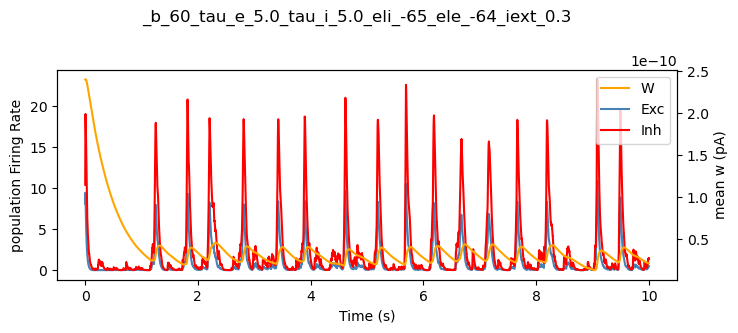

In [14]:
%run MF_script_with_OS.py --b_e=60

2.5178910821069227 -1.6448179736656334
starting
done


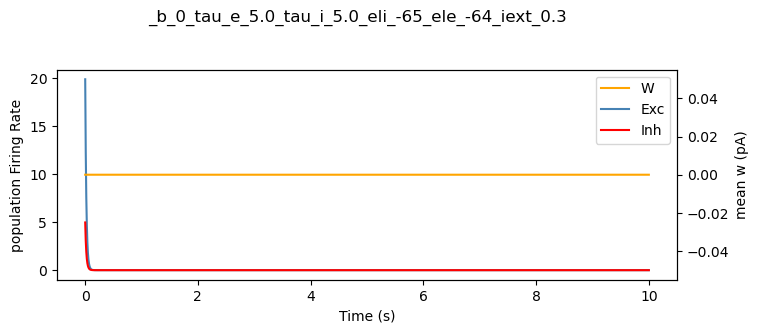

In [74]:
%run MF_script_with_OS.py --b_e=0 --iext=0.3

<a id="whole-brain-model"></a>
### Whole Brain Model

#### Choose a connectome 

You have various options:

1. Get a default connectivity from TVB software

    - `parameters.parameter_connection_between_region['default'] = True`

2. Point to a zip folder (required files included in the zip folder: centres, tract_lengths, weights)

    - `parameters.parameter_connection_between_region['from_file'] = True`
    - `parameters.parameter_connection_between_region['path'] = path/to/zip/file`
    - `parameters.parameter_connection_between_region['conn_name'] = 'Connectivity.zip'` (add the actual zip name)

3. Point to an h5 file

    - `parameters.parameter_connection_between_region['path'] = path/to/h5/file CHECK`

4. Point to an unzipped folder that contains necessarily tract_lengths.txt and weights.txt (optional: region_labels, centres, cortical)

    - `parameters.parameter_connection_between_region['path'] = path/to/folder/containing/files`


In [4]:
# Choose the connectome

path_windows = r"C:\Users\maria\Downloads\tvb_data\tvb_data\connectivity"
path_linux = "/home/maria/Downloads/tvb_data/connectivity"
parameters.parameter_connection_between_region['from_file'] = True
parameters.parameter_connection_between_region['path'] = path_linux
parameters.parameter_connection_between_region['conn_name'] = 'connectivity_76.zip'

##### Set up the parameters of the simulation

In [ ]:
## Set the parameters of the simulation:
run_sim = 2000.0 # ms, length of the simulation
cut_transient = 200.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

In [6]:
simulator = sim_init(parameters)
Nnodes = simulator.number_of_nodes

2024-04-04 17:14:31,890 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


No differences in  model
No differences in  connectivity
No differences in  coupling
No differences in  integrator
If there are no differences you can safely continue: press Y
Overwriting...


#### Run the simulation


Here is an example of changing `tau_e` and `b_e`.

You can instead change `tau_i`, or other values (look at docs of `adjust_parameters`), by setting `tau_i = desired_value` as an argument in the functions:
- `adjust_parameters`
- `get_result`

and set `change_of = 'tau_i'` in:
- `access_results`
- `plot_tvb_results`



In [8]:
# Choose values of b_e and tau_e
bvals = [30]
tau_es = [3.75]

In [12]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,
                       cut_transient=cut_transient, run_sim=run_sim)
    

Simulation Completed successfully


#### Load the Results

In [17]:
# Params to load 
bvals = [5, 60]
tau_es = [3.75, 5]

#Which variables to load:
vars_int = ['E', 'I' ,'W_e']

#Load
result= []
for i, (b_e, tau_e) in enumerate(zip(bvals, tau_es)):
    result_param, for_explan = get_result(parameters,cut_transient, run_sim, b_e = b_e, tau_e = tau_e, vars_int = vars_int)
    result.append(result_param)


Loading:  _b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 1
Loading:  _b_e_60_tau_e_5_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 1

Explaining the indices in result:
The result has a length equal to you different parameter combinations, i.e:
result[0]: for b_e = 5 and tau_e= 3.75
result[1]: for b_e = 60 and tau_e= 5

The result[i] is a list of arrays, every element of a list corresponds to a monitor:
Raw monitor : result[i][0]

Each monitor contains an array with the selected variables of interest, for all the time points and nodes
For example for Raw monitor:
For E : result[i][0][0]
For I : result[i][0][1]
For W_e : result[i][0][2]

These arrays have shape: time_points x number_of_nodes: (18001, 76)


In [ ]:
# For explanation of the indexes of the result, uncomment the following:
    if i==len(bvals)-1:
        access_results(for_explan, bvals, tau_es, change_of='tau_e')

#### Plot the Results

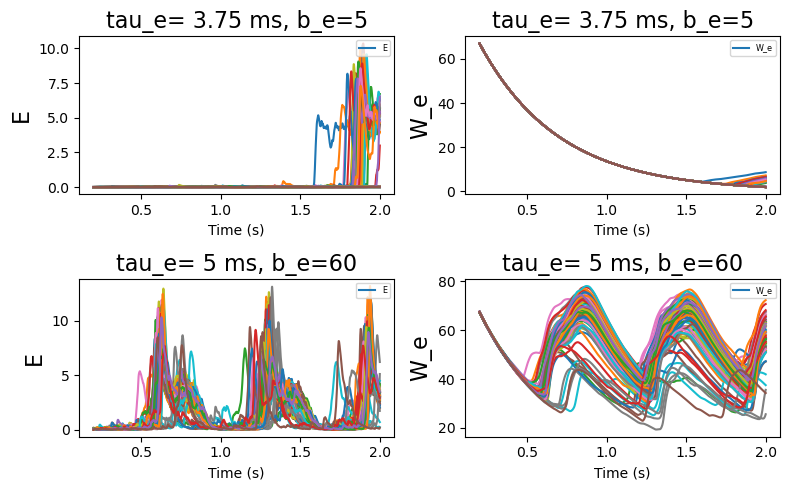

In [19]:
#Plot the results from TVB Simulations

#which monitor 
monitor = 'Raw'

#which variables
var_select = ['E',  'W_e']

#which params (b_e, tau) - to be in the same order as the loading results (see explanations)
params = [[5, 3.75], [60,5]]
plot_tvb_results(parameters,params, result, monitor, for_explan, var_select,cut_transient, run_sim)

<a id="pci"></a>
### Evoked Dynamics and PCI

#### Set up the parameters of the simulation

In [ ]:
## Set the parameters of the simulation:
run_sim = 4000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]

These are additional parameters to adjust for the stimulation

In [ ]:
## Set the parameters of the stimulus 
stimval = 1e-3 #  stimulus strength in kHz - HERE NO ZERO ANYMORE
t_analysis  = 300. #in ms, for PCI analysis

# Loop over seeds to obtain multi5ple realizations of the model
Nseeds = 2 

# Onset time of the stimulus
stimtime_allseeds = np.random.rand(Nseeds)*(run_sim - cut_transient - 2*t_analysis) + t_analysis + cut_transient # shuffle in ms the start time of stimulus 
stimdur = 50 # ms, duration of the stimulus
stimtime_mean = 2500. # ms, time after simulation start (it will be shufled)
stim_region = 5

#### Run Simulation

In [ ]:
# Choose values of b_e and tau_e
bvals = [5]
tau_es = [3.75]

In [ ]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    for seed in range(Nseeds):
        run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,stimval = stimval, nseed=seed,
                       cut_transient=cut_transient, run_sim=run_sim)


#### Calculate PCI

In [ ]:
#Calculate PCI
params = [[5, 3.75, 2], [60, 5, 2]] 

for b_e, tau_e, n_seeds in params:
    calculate_PCI(parameters, n_seeds, run_sim, cut_transient, stimval=stimval, b_e=b_e, tau_e=tau_e, n_trials = 1)

#### Plot PCI #

Loading paper params:
For wake : b_e=5, tau=5.0
For nmda : b_e=30, tau=3.75
For gaba : b_e=30, tau=7.0
For sleep : b_e=120, tau=5.0
Seeds = 60, n_trials=5, stimvals=[1e-05, 0.0001, 0.001]
Creating PCI_all
Creating dataframe


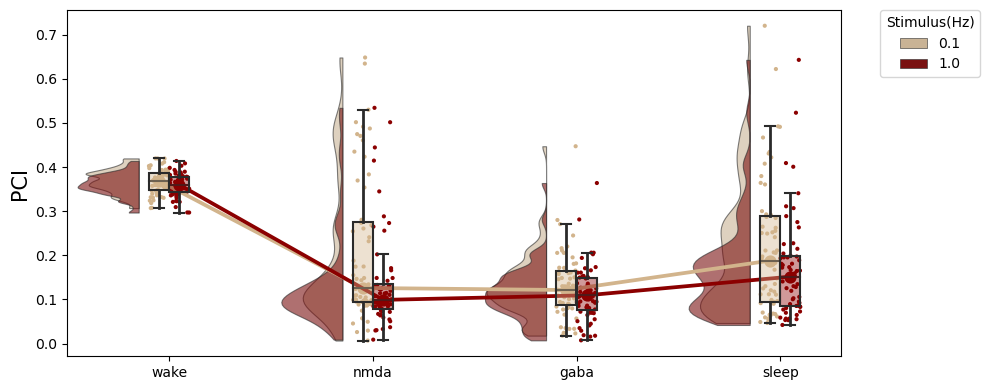

In [20]:
params = [[5, 3.75, 2], [60, 5, 2]] # b_e, tau, nseeds
conditions = ['nmda', 'sleep'] #conditions that the params describe - used for the x tick labels
stimvals = [1e-3] #stimvals to load
n_trials=1 #how many trials were used for the PCI

pick_stim = [1, 0.1] # stimulus strength to plot

#set this to True if you want to plot the already run stims, it will load params automatically
local_folder= True 


plot_raincloud_with_stats(parameters, params, n_trials=n_trials, stimvals=stimvals, pick_stim=pick_stim, conditions= conditions, local_folder=local_folder)

<a class="anchor" id="bold-and-fc"></a>
### Simulating BOLD signal and calculating FC-SC Correlation

#### Set up the parameters of the simulation

In [ ]:
# Do that to initialize the parameters
parameters.__init__()

In [5]:
# Choose the connectome

path_windows = r"C:\Users\maria\Downloads\tvb_data\tvb_data\connectivity"
path_linux = "/home/maria/Downloads/tvb_data/connectivity"
parameters.parameter_connection_between_region['from_file'] = True
parameters.parameter_connection_between_region['path'] = path_linux
parameters.parameter_connection_between_region['conn_name'] = 'connectivity_76.zip'

For the BOLD monitor long simulations are needed, so set a long `run_sim`

In [6]:
## Set the parameters of the simulation:
run_sim = 100000 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

Set `parameter_monitor['Bold'] = True` 
- (if you want you can simulate another monitor)

In [7]:
#Set Bold Monitor
parameters.parameter_monitor['Bold'] = True
# parameters.parameter_monitor['parameter_Bold']['period'] = 2000 

#Deactivate Raw, and keep Temporal Average instead ( faster )
parameters.parameter_monitor['Raw'] = False
parameters.parameter_monitor['TemporalAverage'] = True
parameters.parameter_monitor['parameter_TemporalAverage']['variables_of_interest'] = [0,1]

In [8]:
# Choose values of b_e and tau_e
bvals = [5]
tau_es = [3.75]

#### Run Simulation

In [ ]:
# Run sim

#Set a subfolder where the results will be saved, otherwise they can be overwritten 
additional_path_folder='Bold/'

for b_e, tau_e in zip(bvals, tau_es):
    run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,stimval = stimval, nseed=seed,
                cut_transient=cut_transient, run_sim=run_sim,additional_path_folder=additional_path_folder)


#### Load Results

In [11]:
# Params to load 
bvals = [5]
tau_es = [3.75]

#Which Variables to load
vars_int = ['E' ]

result= []
for i, (b_e, tau_e) in enumerate(zip(bvals, tau_es)):
    result_param, for_explan = get_result(parameters,cut_transient, run_sim, b_e = b_e, tau_e = tau_e, 
    vars_int = vars_int, additional_path_folder=additional_path_folder)
    result.append(result_param)


WARNING    /DATA/Maria/paper_pipeline/functions.py:526: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp = np.array(result[i])
 [py.warnings]


Loading:  _b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 2
2024-04-04 17:03:56,582 - WARNING - py.warnings - /DATA/Maria/paper_pipeline/functions.py:526: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp = np.array(result[i])


Explaining the indices in result:
The result has a length equal to you different parameter combinations, i.e:
result[0]: for b_e = 5 and tau_e= 3.75

The result[i] is a list of arrays, every element of a list corresponds to a monitor:
TemporalAverage monitor : result[i][0]
Bold monitor : result[i][1]

Each monitor contains an array with the selected variables of interest, for all the time points and nodes
For example for TemporalAverage monitor:
For E : result[i][0][0]

These arrays have shape: time_points x 

In [ ]:
# For explanation of the indexes of the result, uncomment the following:
access_results(for_explan, bvals, tau_es, change_of='tau_e')


#### Plot Results


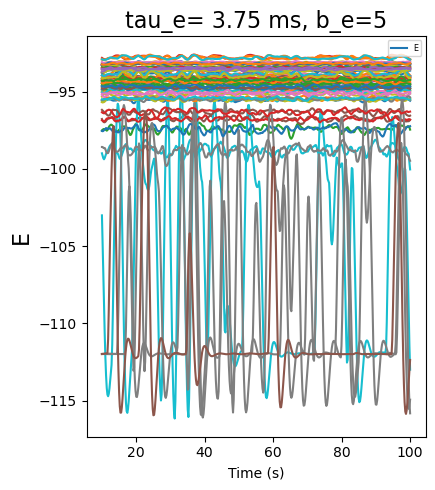

In [38]:
#Plot the results from TVB Simulations

#which monitor 
monitor = 'Bold'

#which variables to plot
var_select = ['E']

#which params (b_e, tau) - to be in the same order as the loading results (see explanations)
params = [[5, 3.75]]
plot_tvb_results(parameters,params, result, monitor, for_explan, var_select,cut_transient, run_sim, 
                 additional_path_folder=additional_path_folder, desired_time=10)

### Compute Corr FC and SC

450 76


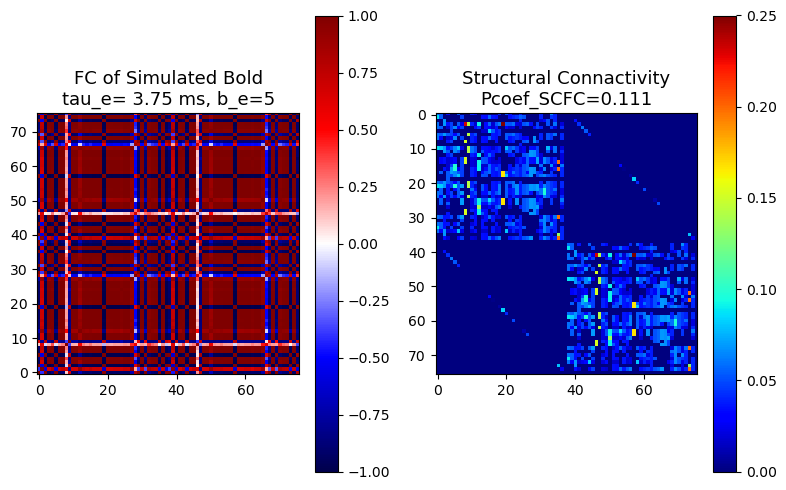

In [97]:
#Add the SC
SC=simulator.connectivity.weights

plot_FC_SC(parameters,params, result, for_explan, cut_transient, run_sim, SC, 
            additional_path_folder=additional_path_folder,desired_time=10)

<a class="anchor" id="dynamical-analysis"></a>
## Dynamical Analysis (to do)

#### Network Simulations and Survival Time

1. First run network simulations for different values of tau_e/tau_i and b_e
2. Calculate the survival time for each combination of tau/b_e

In [59]:
%run net_sims_dyn_analysis.py --help

usage: net_sims_dyn_analysis.py [-h] [--b_e_range B_E_RANGE]
                                [--tau_e_range TAU_E_RANGE]
                                [--tau_i_range TAU_I_RANGE] [--nseeds NSEEDS]
                                [--time TIME] [--save_path SAVE_PATH]
                                [--overwrite OVERWRITE]
                                [--surv_time_calc SURV_TIME_CALC]

optional arguments:
  -h, --help            show this help message and exit
  --b_e_range B_E_RANGE
                        b_e range of values (default: 0,30,1)
  --tau_e_range TAU_E_RANGE
                        tau_e range of values - if you iterate tau_i then set
                        tau_e_range=np.arange(5.,10.,step=500) (default:
                        5.,7.,10)
  --tau_i_range TAU_I_RANGE
                        tau_i range of values - if you iterate tau_e then set
                        tau_i_range=np.arange(5.,10.,step=500) (default:
                        3.,9.,0.1)
  --nseeds NSEEDS  

In [101]:
%run net_sims_dyn_analysis.py --b_e_range '0,20,1' --tau_i_range '3, 7.2, 0.1' --nseeds '0,10,2' --surv_time_calc True --save_path './trials/' --overwrite True --time 5000

Done! Network simulations are saved in ./trials//network_sims/ 
survival time (tau_i_mean_array.npy) 
with the respective values of b_e (tau_i_heatmap_bvals.npy) and 
tau_is (tau_i_heatmap_taus.npy) in ./trials/


You can separately calculate the survival times if you have already run the network simulations:
- adjust the parameters accordingly

In [102]:
bvals = np.arange(0,20,step=1)
tauIv = np.arange(3., 7.2, step=0.1)
tauEv= np.arange(5.,9.,step=10)
Nseeds = np.arange(0,10,2)

if len(tauEv)==1 and len(tauIv)>1:
    tau_i_iter = True
    tau_values = tauIv
elif len(tauEv)>1 and len(tauIv)==1:
    tau_i_iter = False
    tau_values = tauEv

loaduntil = 999

calculate_survival_time(bvals, tau_values, tau_i_iter, Nseeds, save_path ='./trials/', load_until = 999)


Done! Saved in : ./trials/


#### Mean Field and b_critical Calculation


In [73]:
%run calculate_b_crit.py --help

usage: calculate_b_crit.py [-h] [--b_e_range B_E_RANGE]
                           [--tau_e_range TAU_E_RANGE]
                           [--tau_i_range TAU_I_RANGE] [--save_path SAVE_PATH]
                           [--overwrite OVERWRITE]

optional arguments:
  -h, --help            show this help message and exit
  --b_e_range B_E_RANGE
                        b_e range of values (default: [ 0 1 2 3 4 5 6 7 8 9 10
                        11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
                        29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
                        47 48 49 50 51 52 53 54 55 56 57 58 59])
  --tau_e_range TAU_E_RANGE
                        tau_e range of values - if you iterate tau_i then set
                        tau_e_range=np.arange(5.,10.,step=500) (default: [5.])
  --tau_i_range TAU_I_RANGE
                        tau_i range of values - if you iterate tau_e then set
                        tau_i_range=np.arange(5.,10.,step=500) (def

In [105]:
time.shape

(399,)

In [107]:
DT=0.1
AmpStim = 1
plat = 100
TauP=20
t2 = np.arange(0, 5000, DT)
test_input = []
time_peek = 200.
for ji in t2:
	test_input.append(0. + input_rate(ji, time_peek, TauP, 1, AmpStim, plat))

input_bin = bin_array(np.array(test_input), 5, t2)

In [114]:
time[61]

307.45

In [ ]:
file_inh5

In [116]:
b_e = 5.0
tau_i5 = 5.0
tau_i = 7.0

file_inh5=f"./trials/network_sims/b_{b_e}_tau_i_{tau_i5}_tau_e_5.0_ampst_1_seed_2.0_inh.npy"
file_exc5=f"./trials/network_sims/b_{b_e}_tau_i_{tau_i5}_tau_e_5.0_ampst_1_seed_2.0_exc.npy"

file_inh=f"./trials/network_sims/b_{b_e}_tau_i_{tau_i}_tau_e_5.0_ampst_1_seed_2.0_inh.npy"
file_exc=f"./trials/network_sims/b_{b_e}_tau_i_{tau_i}_tau_e_5.0_ampst_1_seed_2.0_exc.npy"


file_time = "./trials/network_sims/b_19.0_tau_i_7.1_tau_e_5.0_ampst_1_seed_8.0_time.npy"

fr_exc5 = np.load(file_exc5)
fr_inh5 = np.load(file_inh5)

fr_exc = np.load(file_exc)
fr_inh = np.load(file_inh)

time = np.load(file_time)

# fig=plt.figure(figsize=(8,3))
# ax1=fig.add_subplot(121)

# ax1.plot(time/1000,fr_inh, 'r')
# ax1.plot(time/1000,fr_exc, 'SteelBlue')
# ax1.plot(time / 1000, input_bin, 'green')
# ax1.set_title(fr"$\tau_i$=5.0 ms")
# ax1.set_xlim(0,1.3)


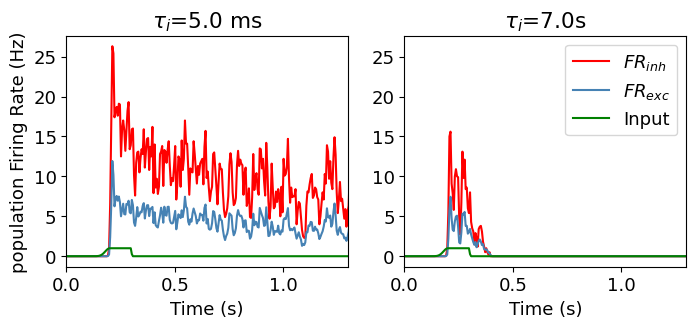

In [135]:

fig=plt.figure(figsize=(8,3))
plt.rcParams.update({'font.size': 13})

ax1=fig.add_subplot(121)
ax3=fig.add_subplot(122, sharey=ax1)

ax1.plot(time/1000,fr_inh5, 'r')
ax1.plot(time/1000,fr_exc5, 'SteelBlue')
ax1.plot(time / 1000, input_bin, 'green')
ax1.set_title(fr"$\tau_i$=5.0 ms")

ax3.plot(time/1000,fr_inh, 'r', label=r"$FR_{inh}$")
ax3.plot(time/1000,fr_exc, 'SteelBlue', label=r"$FR_{exc}$")
ax3.plot(time / 1000, input_bin, 'green', label="Input")
ax3.set_title(fr"$\tau_i$=7.0s")

ax1.set_xlabel('Time (s)')
ax3.set_xlabel('Time (s)')
ax1.set_ylabel('population Firing Rate (Hz)')

ax3.legend()
for ax in [ax1, ax3]:
    ax.set_xlim(0,1.3)

# plt.tight_layout()

In [103]:
%run calculate_b_crit.py --b_e_range '12,20,1' --tau_i_range '3,7.2,0.1' --overwrite=True --save_path='./trials/' 

Done! Saved in  ./trials/


### Plot the heatmap

In [ ]:
#This is an example with few values of tau_i and b_e
load= 'tau_i'
mean_array,taus, bthr, tau_v, bvals = load_survival( load = load, save_path = './trials/')
plot_heatmap_survival(mean_array, taus, tau_v, bvals , bthr,load = load, save_im=False)

Or you can load directly a pre-calculated array with the mean survival time (averaged over seeds) for each combination of tau/b_e : 

In [100]:
load= 'tau_i'
mean_array,taus, bthr, tau_v, bvals = load_survival( load = load, precalc=True)
plot_heatmap_survival(mean_array, taus, tau_v, bvals , bthr,load = load, precalc=True, save_im=False)